# Import Libraries

In [9]:
import numpy as np
import pandas as pd

from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

# Import Data

In [10]:
wine_data = pd.read_csv("winequality-red.csv")

# Describe Data

The data consists of 11 features and one target (output) value. The input features based on physicochemical tests are as follows:

1 - **fixed acidity** - The term refers to the amount of acids which do not evaporate easily during fermentation and aging and end up in the final bottled wine. It is a positive real number measured in grams per liter (g/L). Usually, red wines have fixed acidity values between 4 g/L to 7 g/L, however this range is not strictly fixed.

2 - **volatile acidity** - This feature is the counterpart of fixed acidity, however in this case it measures the amount of volatile acids in wine which are easily evaporating during fermentation and aging. Measured in g/L, usual values are between 0.3 g/L to 0.7 g/L.

3 - **citric acid** - The amount of citric acid in wine, measured in g/L. Usual values range from 0 g/L to 1 g/L.

4 - **residual sugar** - The amount of sugar left in wine after the fermentation process. It is used to balance acidity and makes red wine categorized into dry, semi-sweet and sweet variants. Once again, it is measured in g/L.

5 - **chlorides** - The amount of chloride salts in red wine (typically NaCl). Measured in g/L, typical values range from 0.012 g/L to 0.1 g/L.

6 - **free sulfur dioxide** - Free sulfur dioxide (SO₂) in wine is the portion of sulfur dioxide that is not bound to other molecules and is active as an antimicrobial and antioxidant. It is measured in milligrams per liter (mg/L) and has typical values from 1 mg/L to 30 mg/L.

7 - **total sulfur dioxide** - Total sulfur dioxide in wine includes both free and bound forms of SO₂. Once again, it is measured in mg/L. Typical values range from 10 mg/L to 150 mg/L.

8 - **density** - The density feature shows how close the wine molecules are located to each other, it measures how heavier or lighter the wine is compared to water. Density for wines is measure in grams per cubic centimeter (g/cm³). Typical values range from 0.99 g/cm³ to 1.003 g/cm³.

9 - **pH** - This feature measures the concentration of positive hydrogen ions in wine, which in simple terms shows the acidity of wine. pH values range from 1 to 13, where a pH value of 7 means the substance in completely neutral, lower values indicate acidic environment, and higher values indicate a basic one. The feature has no measure of units. Typical values fall into the range from 3.2 to 3.6.

10 - **sulphates** - The amount of sulphates in wine measured in g/L. Typical value range is from 0.3 g/L to 1 g/L.

11 - **alcohol** - Finally, the last feature shows the percentage of alcohol (ethanol content) present in wine. It is measured in percents and has typical values between 12% to 14.5%.

The output value is the **wine quality score**, which is an **integer** from 0 to 10. Lower scores represent poor wine quality, while high scores represent excellent quality.

Find more information about the dataset and it's origins [here](https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009).

# Exploratory Data Analysis (EDA)


First few lines for display
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            NaN              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8   

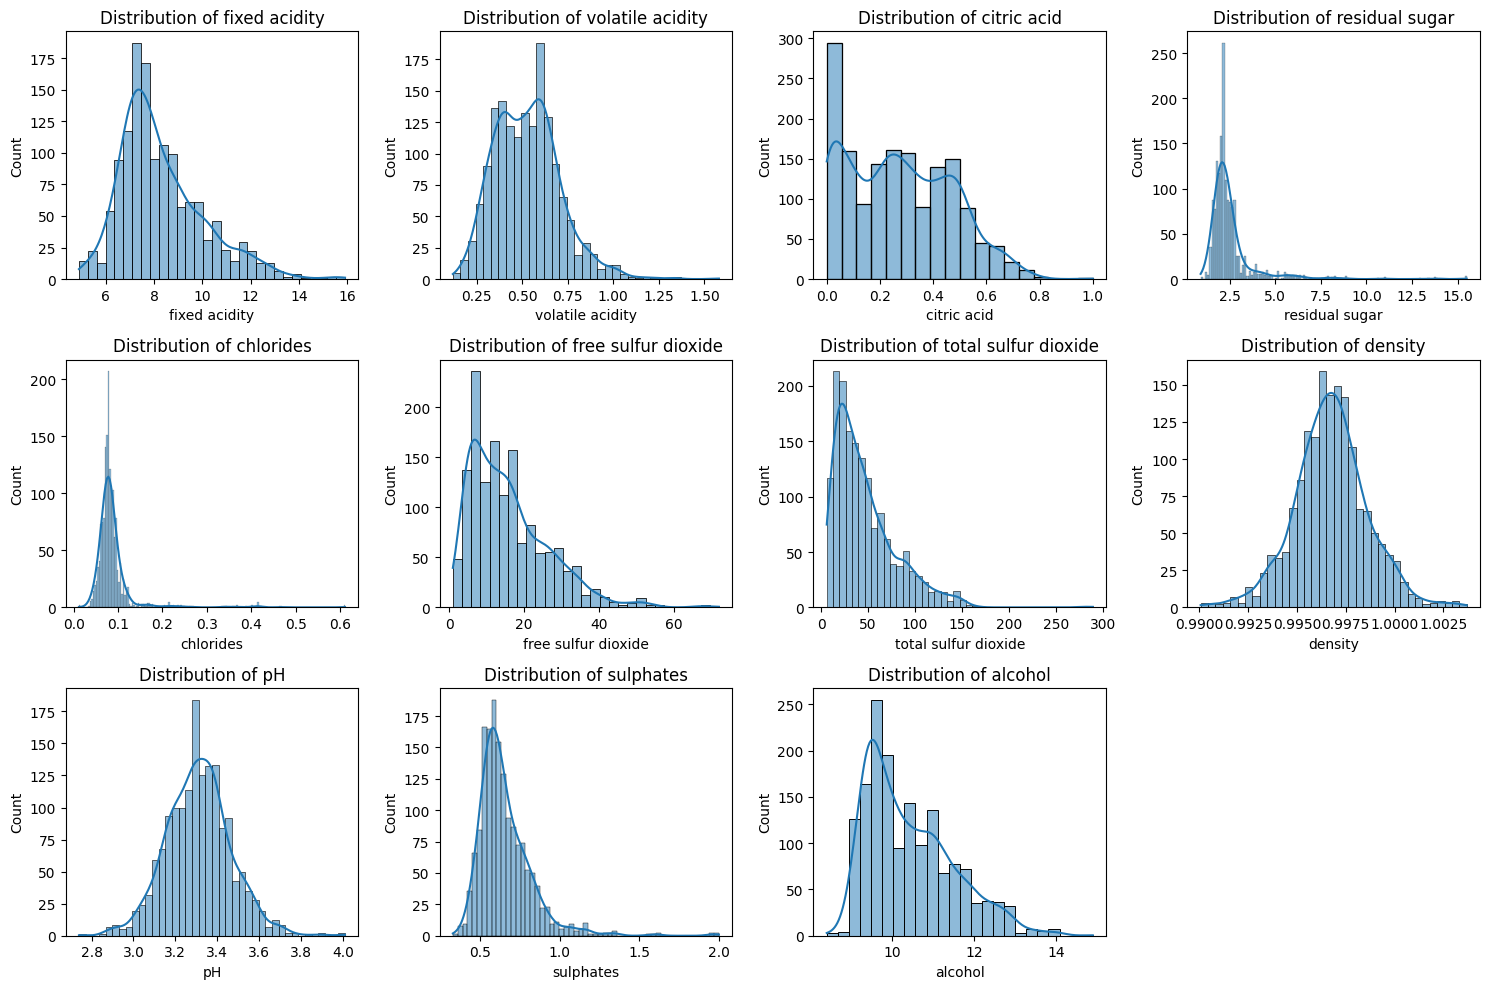


Boxplot Distribution of Features (for detecting outliers)


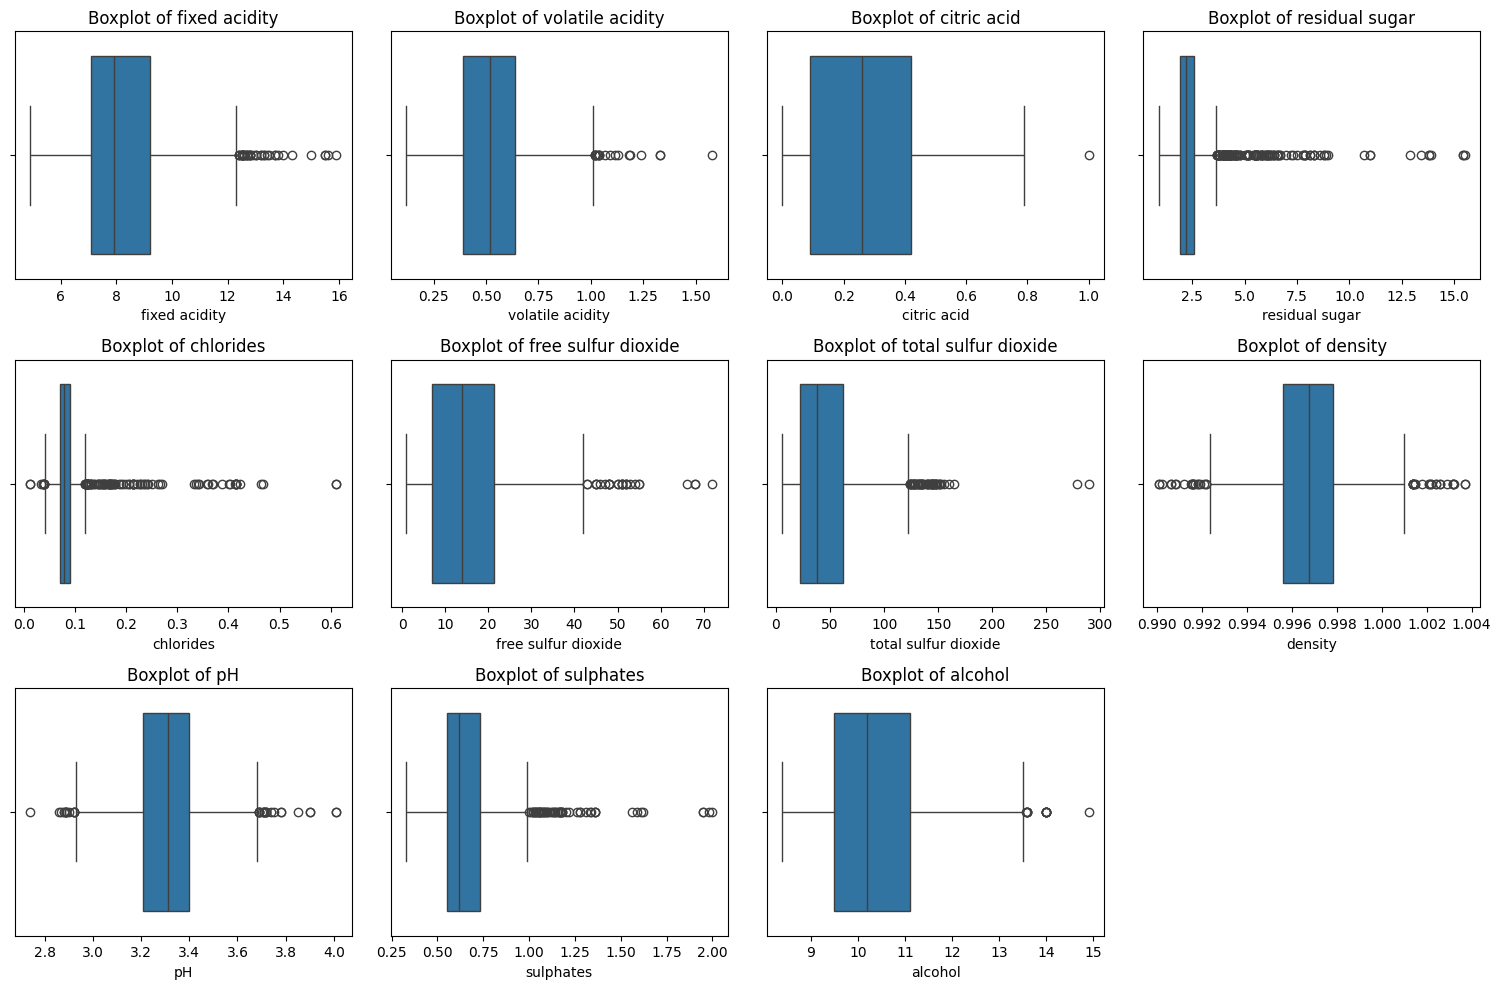


Count of Quality (for understanding if our data is balanced or biased)


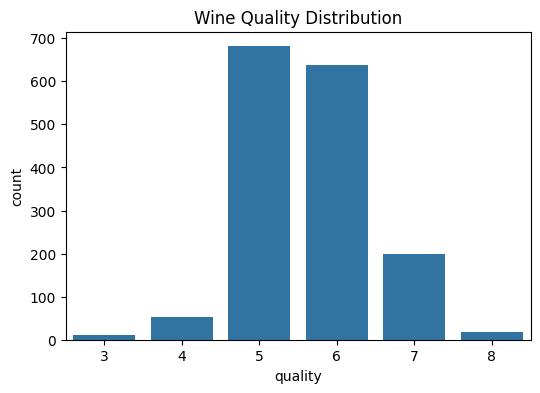


Correlation


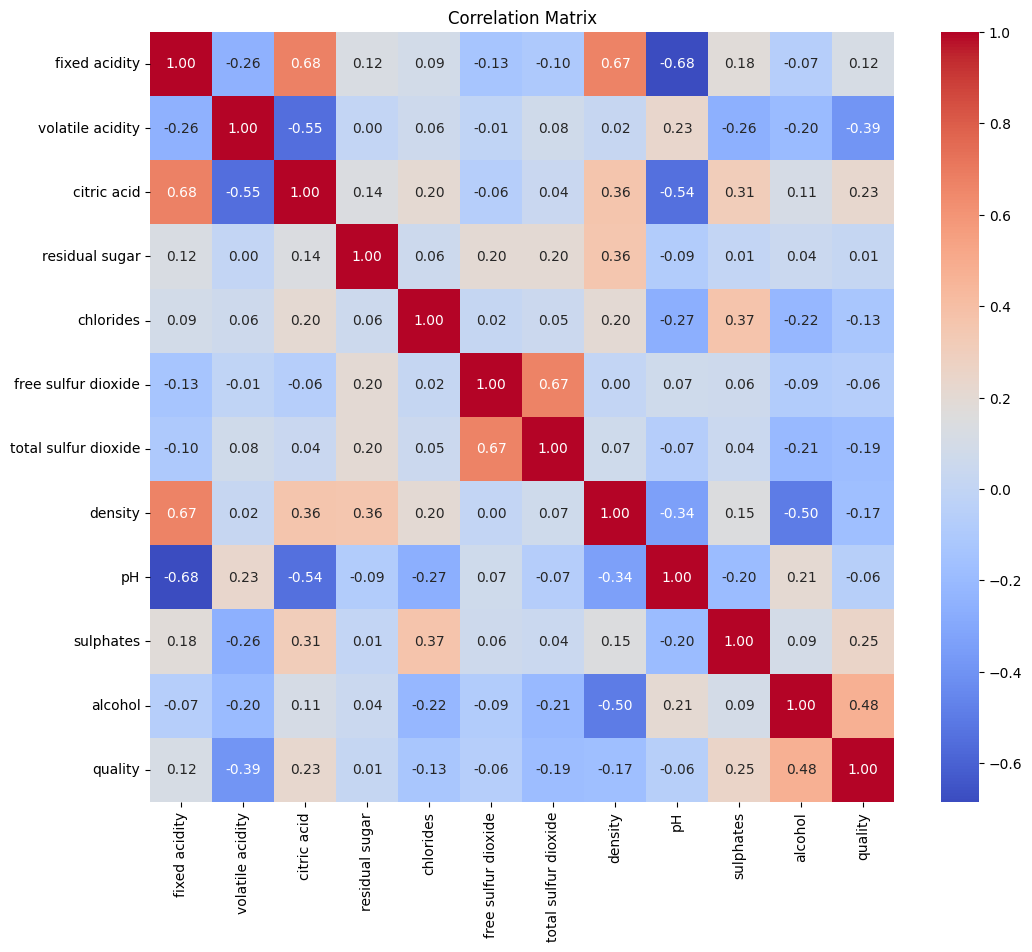


Feature vs Quality


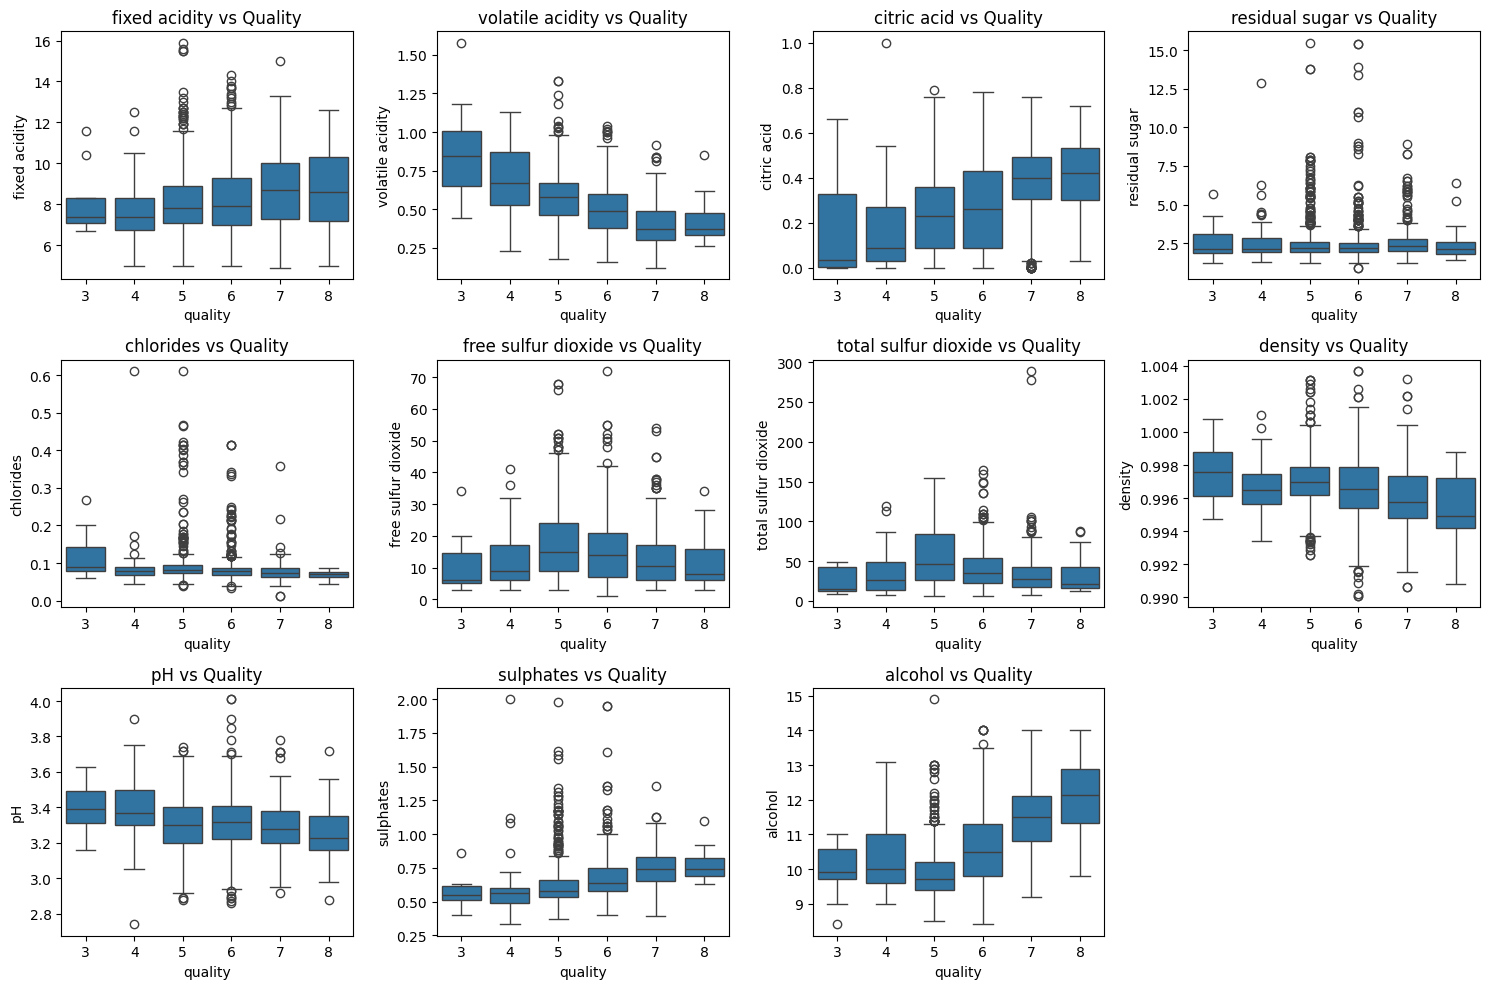


Missing Vales Count


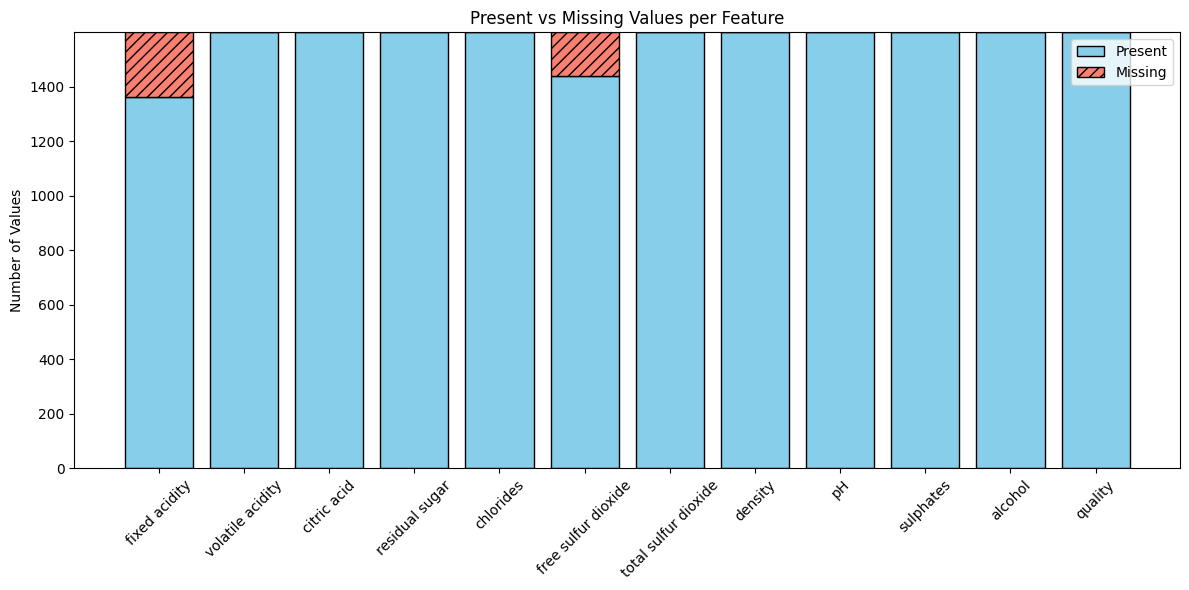


Mean Feature Values per Wine Quality


<Figure size 1400x800 with 0 Axes>

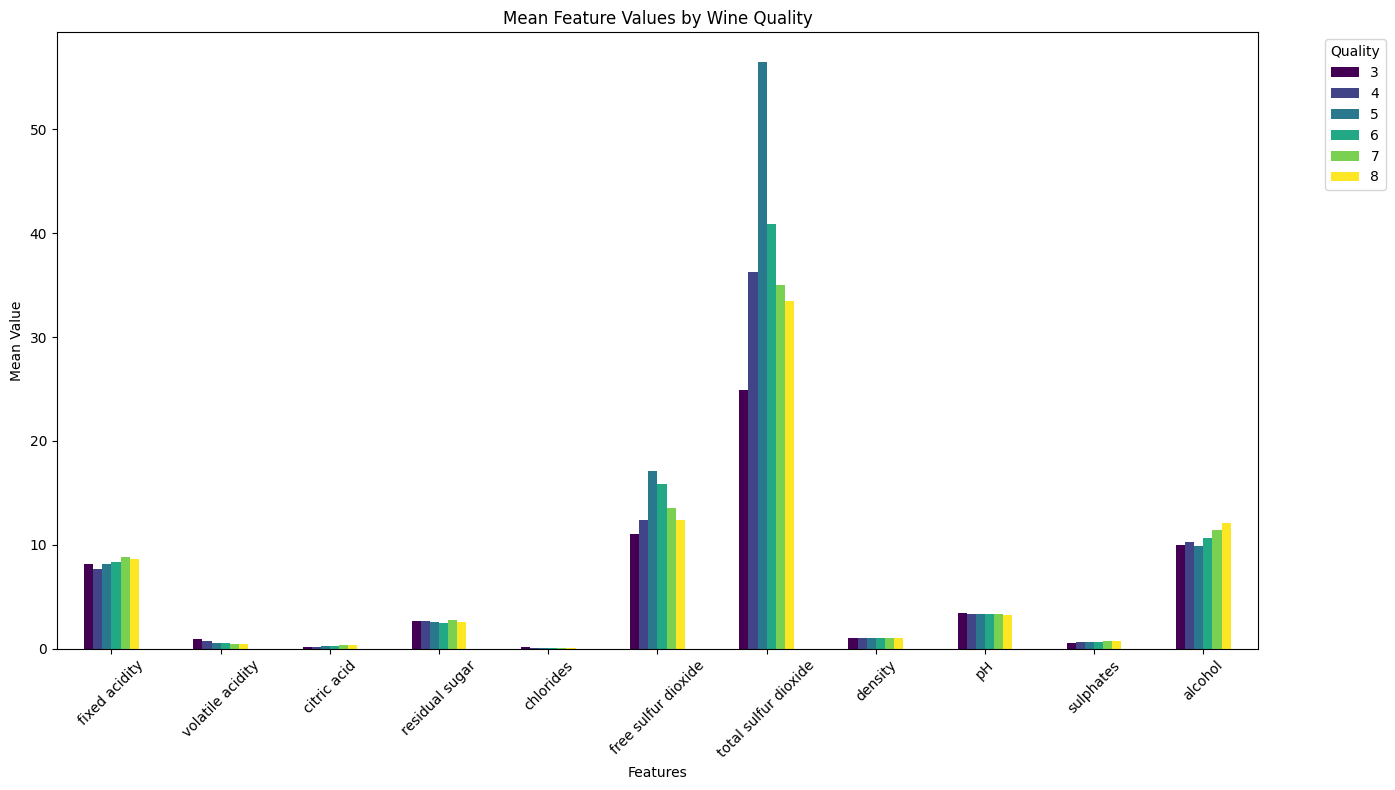

In [11]:
# Satine Aghababyan
import matplotlib.pyplot as plt
import seaborn as sns

df = wine_data

print("\nFirst few lines for display")
print(df.head())

print("\nSummary Statistics")
print(df.describe())

print("\nMissing Values")
print(df.isnull().sum())

print("\nDistribution of Features")
numeric_features = df.columns[:-1]
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_features, 1):
    plt.subplot(3, 4, i)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

#Էս մի հատ նայեք՝ պետք ա թե չէ
print("\nBoxplot Distribution of Features (for detecting outliers)")
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_features, 1):
    plt.subplot(3, 4, i)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

#Էս փակագծերում գրածներս կարանք քոմենթ սարքենք եսլի չտո, կամ հանենք present անելուց կասենք
print("\nCount of Quality (for understanding if our data is balanced or biased)")
plt.figure(figsize=(6, 4))
sns.countplot(x='quality', data=df)
plt.title('Wine Quality Distribution')
plt.show()

print("\nCorrelation")
plt.figure(figsize=(12, 10))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

print("\nFeature vs Quality")
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_features, 1):
    plt.subplot(3, 4, i)
    sns.boxplot(x='quality', y=col, data=df)
    plt.title(f'{col} vs Quality')
plt.tight_layout()
plt.show()

print("\nMissing Vales Count")
total_rows = len(df)
missing_counts = df.isnull().sum()
present_counts = total_rows - missing_counts
columns = df.columns

fig, ax = plt.subplots(figsize=(12, 6))

bars_present = ax.bar(columns, present_counts, color='skyblue', edgecolor='black', label='Present')

bars_missing = ax.bar(columns, missing_counts, bottom=present_counts, color='salmon',
                      edgecolor='black', hatch='///', label='Missing')

ax.set_ylabel('Number of Values')
ax.set_title('Present vs Missing Values per Feature')
plt.xticks(rotation=45)
ax.legend()

plt.tight_layout()
plt.show()


print("\nMean Feature Values per Wine Quality")
grouped_means = df.groupby('quality').mean()

grouped_means_T = grouped_means.T

plt.figure(figsize=(14, 8))
grouped_means_T.plot(kind='bar', figsize=(14, 8), colormap='viridis')

plt.title('Mean Feature Values by Wine Quality')
plt.ylabel('Mean Value')
plt.xlabel('Features')
plt.xticks(rotation=45)
plt.legend(title='Quality', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Data preprocessing

In [12]:
# Tigran Fahradyan
from sklearn.preprocessing import StandardScaler

data = wine_data.to_numpy()

CV = 5

def split_data(data, seed=42):
    np.random.seed(seed)
    indices = np.random.permutation(len(data))
    
    train_end = int(0.9 * len(data))

    train = data[indices[:train_end]]
    test = data[indices[train_end:]]

    return train, test

def replace_nans(train, test):
    train_mean = np.nanmean(train[:, :-1], axis=0)
    for dataset in [train, test]:
        for i in range(dataset.shape[1] - 1):
            nan_mask = np.isnan(dataset[:, i])
            dataset[nan_mask, i] = train_mean[i]
    return train, test

train, test = split_data(data, seed=42)
train, test = replace_nans(train, test)

X_train, y_train = train[:, :-1], train[:, -1].astype(int)
X_test, y_test = test[:, :-1], test[:, -1].astype(int)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modelling

### Naive Bsyes

In [13]:
class NaiveBayes:
    def __init__(self, n_bins=10):
        self.n_bins = n_bins

    def fit(self, X, y):
        self.n_features = X.shape[1]
        self.classes = np.unique(y)
        self.K = len(self.classes)
        self.N = len(y)

        self.class_counts = {c: np.sum(y == c) for c in self.classes}
        self.priors = {
            c: (self.class_counts[c] + 1) / (self.N + self.K)
            for c in self.classes
        }

        self.bins = []
        self.X_binned = np.zeros_like(X, dtype=int)
        for i in range(self.n_features):
            col, edges = pd.cut(X[:, i], bins=self.n_bins, retbins=True, labels=False, duplicates='drop')
            self.X_binned[:, i] = col
            self.bins.append(edges)

        self.feature_counts = {
            c: np.zeros((self.n_features, self.n_bins), dtype=int)
            for c in self.classes
        }

        for x, label in zip(self.X_binned, y):
            for i, bin_idx in enumerate(x):
                self.feature_counts[label][i][bin_idx] += 1

    def _predict_sample(self, x):
        x_binned = []
        for i, val in enumerate(x):
            bin_idx = np.digitize(val, self.bins[i]) - 1
            bin_idx = min(max(bin_idx, 0), self.n_bins - 1)
            x_binned.append(bin_idx)

        best_class = None
        max_log_prob = -np.inf

        for c in self.classes:
            log_prob = np.log(self.priors[c])

            for i, bin_idx in enumerate(x_binned):
                count = self.feature_counts[c][i][bin_idx]
                total = self.class_counts[c]
                prob = (count + 1) / (total + self.K)
                log_prob += np.log(prob)

            if log_prob > max_log_prob:
                max_log_prob = log_prob
                best_class = c

        return best_class

    def predict(self, X):
        return np.array([self._predict_sample(x) for x in X])

    def score(self, X, y):
        return np.mean(self.predict(X) == y)
    

from sklearn.model_selection import KFold
from itertools import product

hparams = {
    "n_bins": [5, 10, 20, 30]
}

param_combinations = list(product(*hparams.values()))
param_names = list(hparams.keys())

best_score = -1
best_params = None
best_model = None

for combo in param_combinations:
    params = dict(zip(param_names, combo))
    scores = []
    
    kf = KFold(n_splits=CV, shuffle=True, random_state=42)
    for train_index, val_index in kf.split(X_train):
        X_tr, X_val = X_train[train_index], X_train[val_index]
        y_tr, y_val = y_train[train_index], y_train[val_index]

        nb = NaiveBayes(**params)
        nb.fit(X_tr, y_tr)
        score = nb.score(X_val, y_val)
        scores.append(score)

    avg_score = np.mean(scores)
    
    if avg_score > best_score:
        best_score = avg_score
        best_params = params
        best_model = NaiveBayes(**params)
        best_model.fit(X_train, y_train)

test_preds = best_model.predict(X_test)

print(f"The best hparam configuration for Naive Bayes is {best_params} with score {best_score:.4f}")

The best hparam configuration for Naive Bayes is {'n_bins': 5} with score 0.5691


### Gaussian Naive Bayes

In [14]:
from sklearn.naive_bayes import GaussianNB

hparams_gnb = {
    "var_smoothing": [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

gnb = GaussianNB()

grid_search_gnb = GridSearchCV(
    gnb,
    param_grid=hparams_gnb,
    scoring="f1_weighted",
    cv=CV
)
grid_search_gnb.fit(X_train, y_train)

best_gnb = grid_search_gnb.best_estimator_

gnb_test_preds = best_gnb.predict(X_test)

print(f"The best hparam configuration for GaussianNB is {grid_search_gnb.best_params_} with score {grid_search_gnb.best_score_:.4f}")

The best hparam configuration for GaussianNB is {'var_smoothing': 1e-05} with score 0.5598


### Decision Tree

In [15]:
from sklearn.tree import DecisionTreeClassifier

hparams = {
    "criterion": ["gini", "entropy"],
    "splitter": ["best", "random"],
}

decision_tree = DecisionTreeClassifier(random_state=42)
grid_search_decision_tree = GridSearchCV(
    decision_tree,
    param_grid=hparams,
    scoring="f1_weighted",
    cv=CV
)
grid_search_decision_tree.fit(X_train, y_train)

dt = grid_search_decision_tree.best_estimator_

print(f"The best hparam configuration for decision tree is {grid_search_decision_tree.best_params_} with score {grid_search_decision_tree.best_score_:.4f}")

decision_tree_test_preds = grid_search_decision_tree.predict(X_test)

The best hparam configuration for decision tree is {'criterion': 'entropy', 'splitter': 'best'} with score 0.6009


### k-nearest neighbour

In [16]:
from sklearn.neighbors import KNeighborsClassifier

knn_hparams = {
    "n_neighbors": [3, 5, 7, 9, 11],
    "weights": ["uniform", "distance"]
}

knn = KNeighborsClassifier()
grid_search_knn = GridSearchCV(
    knn,
    param_grid=knn_hparams,
    scoring="f1_weighted",
    cv=CV
)

grid_search_knn.fit(X_train_scaled, y_train)

knn_best = grid_search_knn.best_estimator_

print(f"The best hparam configuration for knn is {grid_search_knn.best_params_} with score {grid_search_knn.best_score_:.4f}")

knn_test_preds = knn_best.predict(X_test_scaled)

The best hparam configuration for knn is {'n_neighbors': 11, 'weights': 'distance'} with score 0.6104


### Random Forest

In [17]:
from sklearn.ensemble import RandomForestClassifier

hparams_rf = {
    "n_estimators": [50, 100],
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "bootstrap": [True, False]
}

random_forest = RandomForestClassifier(random_state=42)

grid_search_rf = GridSearchCV(
    random_forest,
    param_grid=hparams_rf,
    scoring="f1_weighted",
    cv=CV,
    n_jobs=-1
)
grid_search_rf.fit(X_train, y_train)

best_rf = grid_search_rf.best_estimator_

rf_test_preds = best_rf.predict(X_test)

print(f"The best hparam configuration for Random Forest is {grid_search_rf.best_params_} with score {grid_search_rf.best_score_:.4f}")

The best hparam configuration for Random Forest is {'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100} with score 0.6609


### Linear Discriminant Analysis

In [18]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid

hparam_grid = [
    {"solver": ["svd"], "shrinkage": [None]},
    {"solver": ["lsqr"], "shrinkage": [None, "auto", 0.1, 0.5, 0.9]},
    {"solver": ["eigen"], "shrinkage": [None, "auto", 0.1, 0.5, 0.9]},
]


param_grid = list(ParameterGrid(hparam_grid))

lda = LinearDiscriminantAnalysis()

grid_search_lda = GridSearchCV(
    LinearDiscriminantAnalysis(),
    param_grid=hparam_grid,
    scoring="f1_weighted",
    cv=CV,
    n_jobs=-1,
    error_score='raise'
)


grid_search_lda.fit(X_train, y_train)

best_lda = grid_search_lda.best_estimator_
lda_test_preds = best_lda.predict(X_test)

print(f"The best hparam configuration for LDA is {grid_search_lda.best_params_} with score {grid_search_lda.best_score_:.4f}")

The best hparam configuration for LDA is {'shrinkage': None, 'solver': 'svd'} with score 0.5722


### Logistic Regression

In [19]:
from sklearn.linear_model import LogisticRegression

logreg_hparams = {
    "penalty": [None, "l2"],
    "C": [0.001, 0.01, 0.1, 1, 10, 100],
    "solver": ["lbfgs", "newton-cg", "newton-cholesky", "sag"]
}

logreg = LogisticRegression()
grid_search_logreg = GridSearchCV(
    logreg,
    param_grid=logreg_hparams,
    scoring="f1_weighted",
    cv=CV
)

grid_search_logreg.fit(X_train_scaled, y_train)

logreg_best = grid_search_logreg.best_estimator_

print(f"The best hparam configuration for logistic regression is {grid_search_logreg.best_params_} with score {grid_search_logreg.best_score_:.4f}")

logreg_test_preds = logreg_best.predict(X_test_scaled)

The best hparam configuration for logistic regression is {'C': 0.001, 'penalty': None, 'solver': 'newton-cg'} with score 0.5715


### Support Vector Machine

In [20]:
from sklearn.svm import SVC

svc_hparams = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100],
    "kernel": ["linear", "poly", "rbf"]
}

svc = SVC()
grid_search_svc = GridSearchCV(
    svc,
    param_grid=svc_hparams,
    scoring="f1_weighted",
    cv=CV
)
grid_search_svc.fit(X_train_scaled, y_train)

svc_best = grid_search_svc.best_estimator_

print(f"The best hparam configuration for support vector machine is {grid_search_svc.best_params_} with score {grid_search_svc.best_score_:.4f}")

svc_test_preds = svc_best.predict(X_test_scaled)

The best hparam configuration for support vector machine is {'C': 10, 'kernel': 'rbf'} with score 0.5923


### Quadratic Discriminant Analysis

In [21]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

qda_hparams = {
    'reg_param': [0.0, 0.01, 0.1, 0.5, 0.9],
    'tol': [1e-4, 1e-3, 1e-2, 1e-1]
}

qda = QuadraticDiscriminantAnalysis()
grid_search_qda = GridSearchCV(
    qda,
    param_grid=qda_hparams,
    scoring="f1_weighted",
    cv=CV
)
grid_search_qda.fit(X_train, y_train)

qda_best = grid_search_qda.best_estimator_

print(f"The best hparam configuration for quadratic discriminant analysis is {grid_search_qda.best_params_} with score {grid_search_qda.best_score_:.4f}")

qda_test_preds = qda_best.predict(X_test)

The best hparam configuration for quadratic discriminant analysis is {'reg_param': 0.1, 'tol': 0.0001} with score 0.5452


# Model Evaluation

Naive Bayes
Accuracy: 0.5938
Precision (macro): 0.3448
Recall (macro): 0.3622
F1 Score (macro): 0.3327
Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.33      0.12      0.18         8
           5       0.62      0.80      0.70        56
           6       0.67      0.47      0.55        75
           7       0.44      0.78      0.56        18
           8       0.00      0.00      0.00         1

    accuracy                           0.59       160
   macro avg       0.34      0.36      0.33       160
weighted avg       0.60      0.59      0.58       160



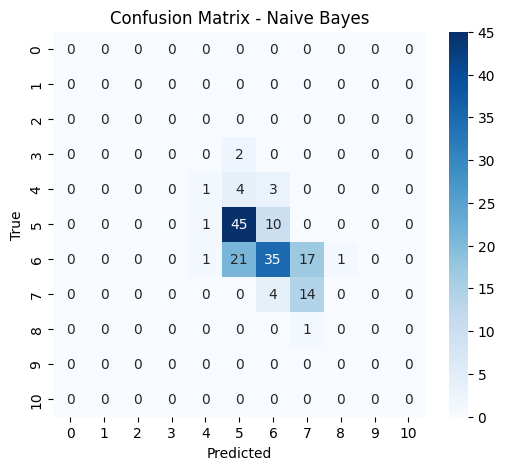

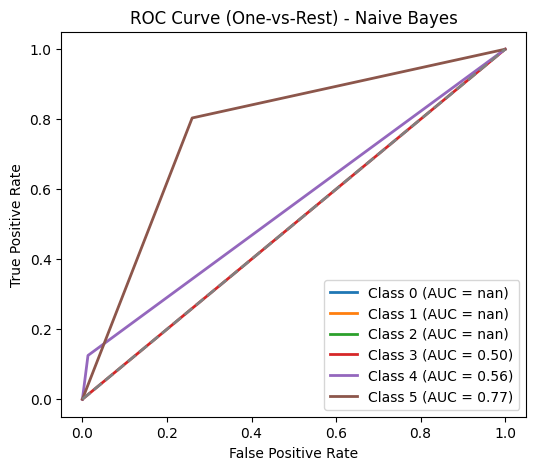



Gaussian Naive Bayes
Accuracy: 0.5750
Precision (macro): 0.2811
Recall (macro): 0.3268
F1 Score (macro): 0.2948
Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         8
           5       0.61      0.73      0.67        56
           6       0.66      0.51      0.57        75
           7       0.42      0.72      0.53        18
           8       0.00      0.00      0.00         1

    accuracy                           0.57       160
   macro avg       0.28      0.33      0.29       160
weighted avg       0.57      0.57      0.56       160



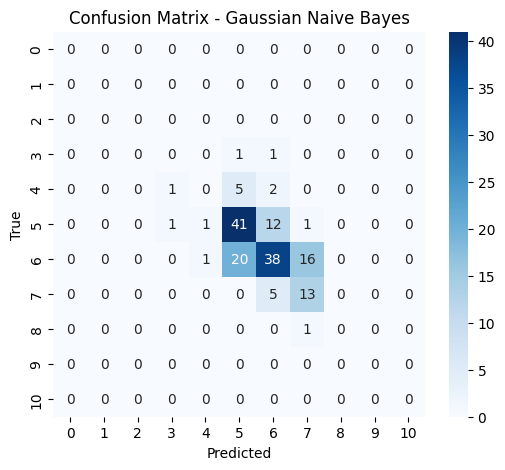

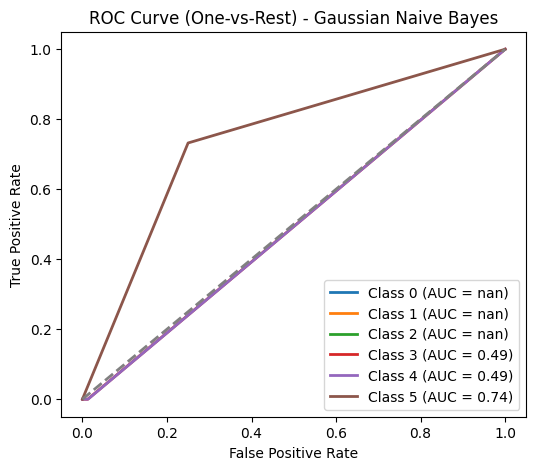



K-Nearest Neighbour
Accuracy: 0.6875
Precision (macro): 0.3312
Recall (macro): 0.3543
F1 Score (macro): 0.3419
Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         8
           5       0.65      0.77      0.70        56
           6       0.76      0.75      0.75        75
           7       0.58      0.61      0.59        18
           8       0.00      0.00      0.00         1

    accuracy                           0.69       160
   macro avg       0.33      0.35      0.34       160
weighted avg       0.65      0.69      0.67       160



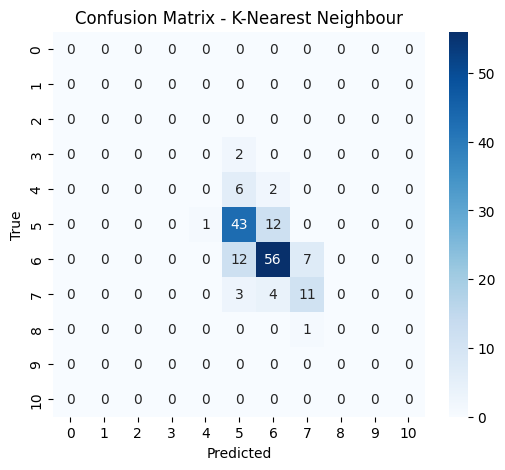

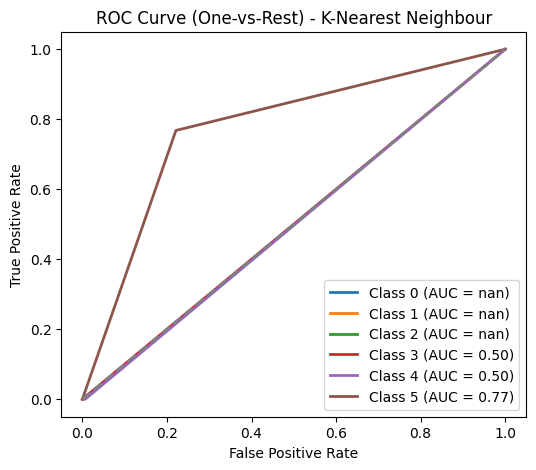



Quadratic Discriminant Analysis
Accuracy: 0.5250
Precision (macro): 0.2443
Recall (macro): 0.2646
F1 Score (macro): 0.2532
Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         8
           5       0.56      0.68      0.61        56
           6       0.56      0.52      0.54        75
           7       0.35      0.39      0.37        18
           8       0.00      0.00      0.00         1

    accuracy                           0.53       160
   macro avg       0.24      0.26      0.25       160
weighted avg       0.50      0.53      0.51       160



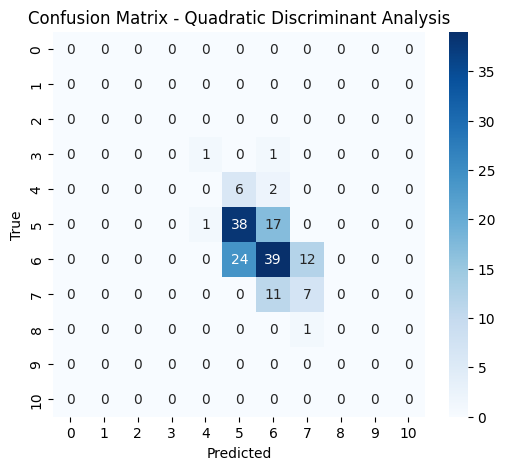

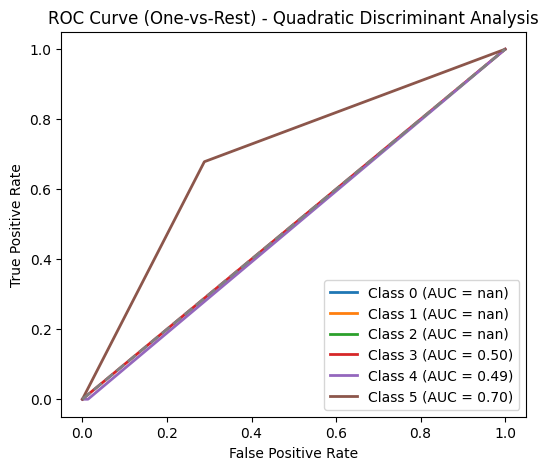



Support Vector Machine
Accuracy: 0.7000
Precision (macro): 0.4002
Recall (macro): 0.3866
F1 Score (macro): 0.3836
Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.33      0.12      0.18         8
           5       0.66      0.82      0.73        56
           6       0.78      0.71      0.74        75
           7       0.63      0.67      0.65        18
           8       0.00      0.00      0.00         1

    accuracy                           0.70       160
   macro avg       0.40      0.39      0.38       160
weighted avg       0.68      0.70      0.69       160



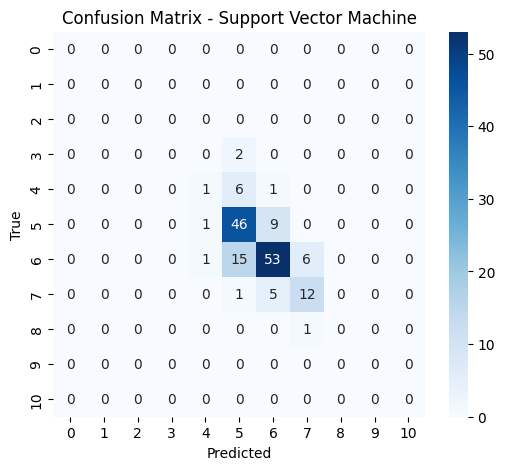

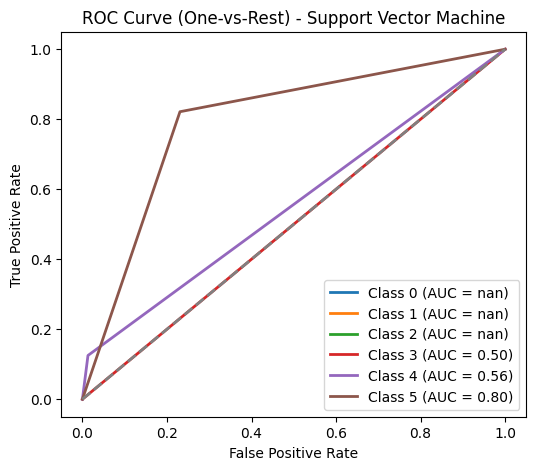



Logistic Regression
Accuracy: 0.6625
Precision (macro): 0.3206
Recall (macro): 0.3454
F1 Score (macro): 0.3320
Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         8
           5       0.64      0.77      0.70        56
           6       0.70      0.69      0.70        75
           7       0.58      0.61      0.59        18
           8       0.00      0.00      0.00         1

    accuracy                           0.66       160
   macro avg       0.32      0.35      0.33       160
weighted avg       0.62      0.66      0.64       160



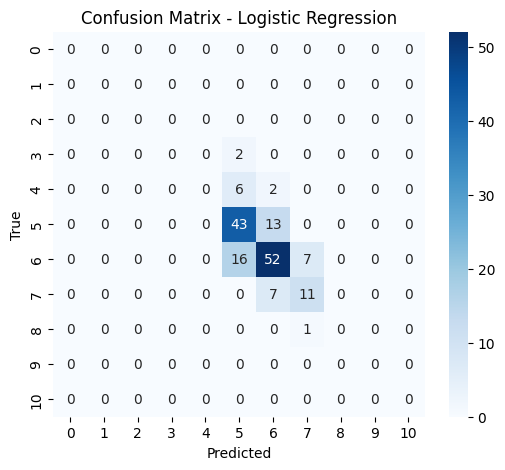

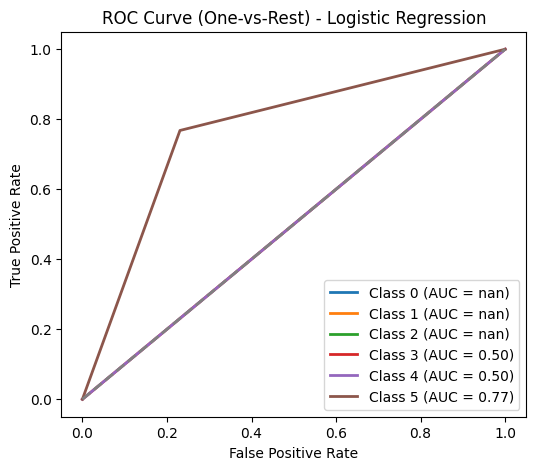



Decision Tree
Accuracy: 0.6312
Precision (macro): 0.3104
Recall (macro): 0.3320
F1 Score (macro): 0.3198
Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         8
           5       0.69      0.71      0.70        56
           6       0.69      0.67      0.68        75
           7       0.48      0.61      0.54        18
           8       0.00      0.00      0.00         1

    accuracy                           0.63       160
   macro avg       0.31      0.33      0.32       160
weighted avg       0.62      0.63      0.62       160



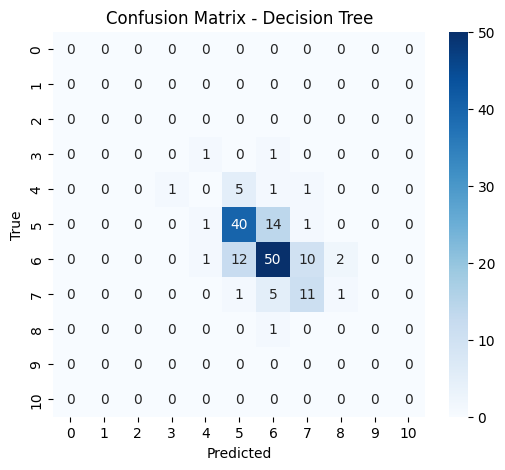

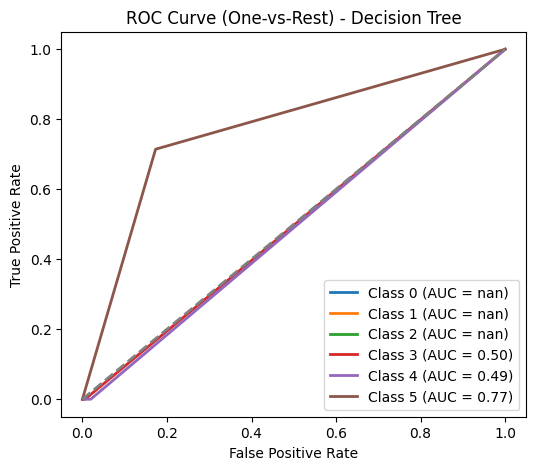



Random Forest
Accuracy: 0.7375
Precision (macro): 0.3662
Recall (macro): 0.3891
F1 Score (macro): 0.3765
Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         8
           5       0.69      0.84      0.76        56
           6       0.78      0.77      0.78        75
           7       0.72      0.72      0.72        18
           8       0.00      0.00      0.00         1

    accuracy                           0.74       160
   macro avg       0.37      0.39      0.38       160
weighted avg       0.69      0.74      0.71       160



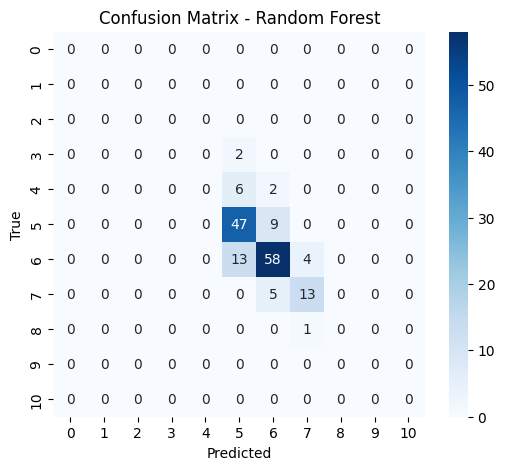

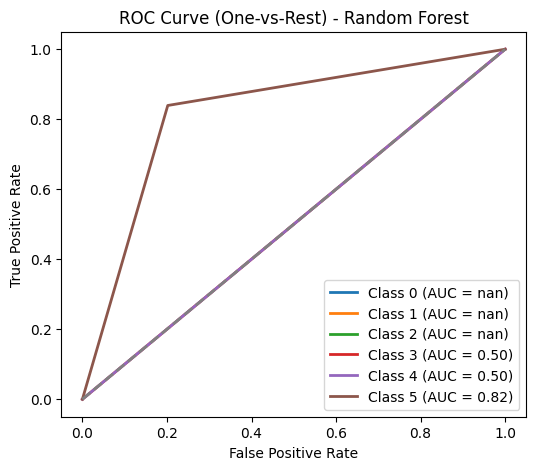



Linear Discriminant Analysis
Accuracy: 0.6250
Precision (macro): 0.3038
Recall (macro): 0.3383
F1 Score (macro): 0.3180
Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         8
           5       0.64      0.75      0.69        56
           6       0.69      0.61      0.65        75
           7       0.50      0.67      0.57        18
           8       0.00      0.00      0.00         1

    accuracy                           0.62       160
   macro avg       0.30      0.34      0.32       160
weighted avg       0.60      0.62      0.61       160



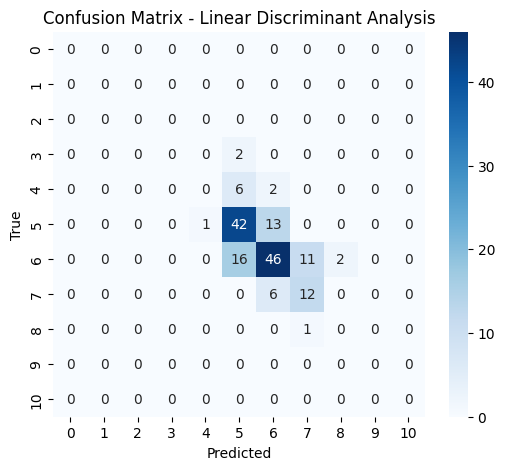

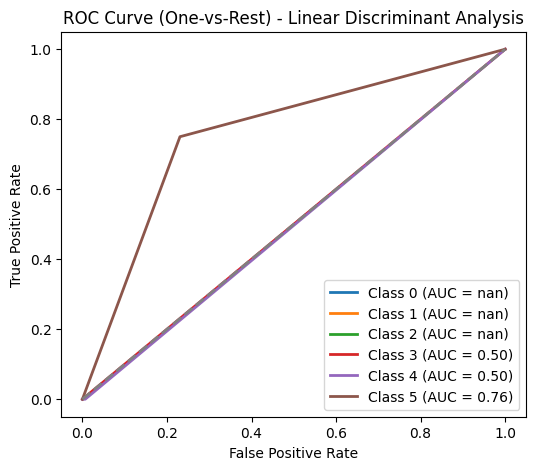

In [24]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize

def evaluate_model(name, y_true, y_pred, num_classes):
    print(f"{name}")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision (macro): {precision_score(y_true, y_pred, average='macro'):.4f}")
    print(f"Recall (macro): {recall_score(y_true, y_pred, average='macro'):.4f}")
    print(f"F1 Score (macro): {f1_score(y_true, y_pred, average='macro'):.4f}")
    
    print("Classification Report:")
    print(classification_report(y_true, y_pred))
    
    all_classes = list(range(0, 11))
    cm = confusion_matrix(y_true, y_pred, labels=all_classes)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(0, 11), yticklabels=range(0, 11))
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

#ROC curve
    if num_classes == 2:
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        roc_auc = auc(fpr, tpr)
        
        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve - {name}")
        plt.legend(loc="lower right")
        plt.show()
        
    elif num_classes > 2:
        y_true_bin = label_binarize(y_true, classes=range(num_classes))
        fpr, tpr, roc_auc = {}, {}, {}
        for i in range(num_classes):
            fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred == i)
            roc_auc[i] = auc(fpr[i], tpr[i])

        plt.figure(figsize=(6, 5))
        for i in range(num_classes):
            plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
        plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve (One-vs-Rest) - {name}")
        plt.legend(loc="lower right")
        plt.show()
    
    print("\n")

num_classes = len(np.unique(y_test))
evaluate_model("Naive Bayes", y_test, test_preds, num_classes)
evaluate_model("Gaussian Naive Bayes", y_test, gnb_test_preds, num_classes)
evaluate_model("K-Nearest Neighbour", y_test, knn_test_preds, num_classes)
evaluate_model("Quadratic Discriminant Analysis", y_test, qda_test_preds, num_classes)
evaluate_model("Support Vector Machine", y_test, svc_test_preds, num_classes)
evaluate_model("Logistic Regression", y_test, logreg_test_preds, num_classes)
evaluate_model("Decision Tree", y_test, decision_tree_test_preds, num_classes)
evaluate_model("Random Forest", y_test, rf_test_preds, num_classes)
evaluate_model("Linear Discriminant Analysis", y_test, lda_test_preds, num_classes)

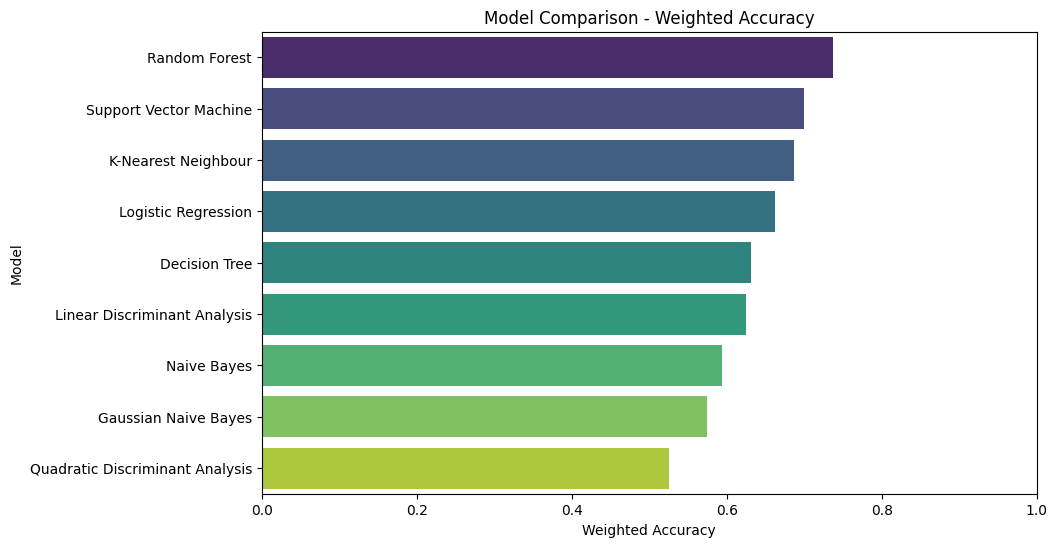

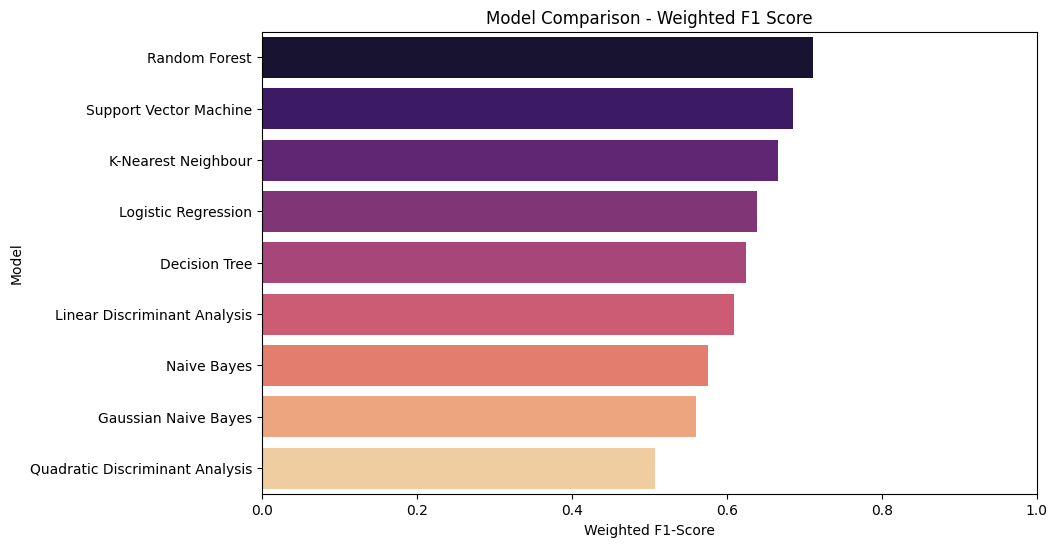

In [23]:
from sklearn.metrics import accuracy_score, f1_score

results = {
    "Model": [],
    "Weighted Accuracy": [],
    "Weighted F1-Score": []
}

model_predictions = {
    "Naive Bayes": test_preds,
    "Gaussian Naive Bayes": gnb_test_preds,
    "K-Nearest Neighbour": knn_test_preds,
    "Quadratic Discriminant Analysis": qda_test_preds,
    "Support Vector Machine": svc_test_preds,
    "Logistic Regression": logreg_test_preds,
    "Decision Tree": decision_tree_test_preds,
    "Random Forest": rf_test_preds,
    "Linear Discriminant Analysis": lda_test_preds
}

for model_name, preds in model_predictions.items():
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, average='weighted')
    results["Model"].append(model_name)
    results["Weighted Accuracy"].append(acc)
    results["Weighted F1-Score"].append(f1)

import pandas as pd

results_df = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
sns.barplot(x="Weighted Accuracy", y="Model", data=results_df.sort_values("Weighted Accuracy", ascending=False), palette="viridis")
plt.title("Model Comparison - Weighted Accuracy")
plt.xlim(0, 1)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x="Weighted F1-Score", y="Model", data=results_df.sort_values("Weighted F1-Score", ascending=False), palette="magma")
plt.title("Model Comparison - Weighted F1 Score")
plt.xlim(0, 1)
plt.show()